In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import contaminante as ct

import warnings
import lightkurve as lk

warnings.filterwarnings("ignore")
plt.style.use('science')

In [37]:
# cand = pd.read_csv('candidates2.txt', delimiter='\t', dtype={'KIC': str})
# cand
df = pd.read_csv("../data/catalogues/rev_AF_stars.csv", dtype={'kic': str})

In [38]:
koi = pd.read_csv('cumulative_2021.05.01_20.40.11.csv', dtype={'kepid': str}, skiprows=146)
# cand = pd.merge(cand, koi, left_on='KIC', right_on='kepid')
# m = koi.koi_disposition != 'FALSE POSITIVE'
# m &= koi.koi_prad < 200
# koi = koi[m]
# candidates = cand[~cand.KIC.isin(koi.kepid)].sort_values('KIC', ascending=False)['KIC'].values # New candidates


In [36]:
# cand[~cand.KIC.isin(koi.kepid)]

,KIC


In [37]:
pd.merge(cand, koi, left_on='KIC', right_on='kepid')[['KIC', 'koi_disposition']]

,KIC,koi_disposition
0,9655419,FALSE POSITIVE
1,9289704,CANDIDATE
2,8912730,FALSE POSITIVE
3,7779942,FALSE POSITIVE
4,7618364,FALSE POSITIVE
5,5702637,FALSE POSITIVE
6,5565497,FALSE POSITIVE
7,5302643,FALSE POSITIVE
8,5202905,CONFIRMED
9,5202905,CONFIRMED


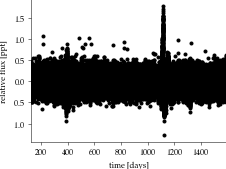

In [18]:
ii = 0
row = df[df.kic == candidates[ii]].squeeze()
f = glob.glob(f"../prewhitening/results/spline and BIC/prewhitened/*{candidates[ii]}*")[0]
lc = lk.LightCurve(*np.loadtxt(f, unpack=True))#.flatten(window_length=201, break_tolerance=11).remove_outliers(sigma_upper=5, sigma_lower=5)
time, flux, flux_err = lc.time.value, lc.flux.value, lc.flux_err.value

m = np.ones_like(time, dtype=bool)
ref_time = 0
x = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
y = np.ascontiguousarray(flux[m], dtype=np.float64)
#
plt.plot(x, y, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

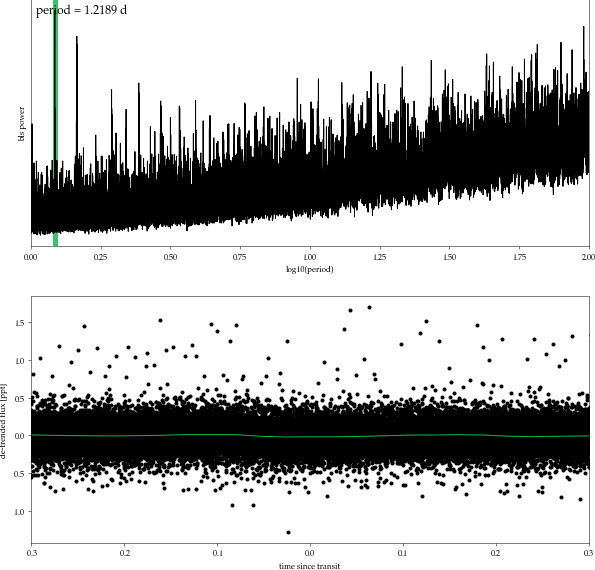

In [19]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(100), 50000))
# period_grid = np.linspace(20, 40, 1000)

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], y[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")



In [20]:


from transitleastsquares import transitleastsquares
model = transitleastsquares(time, flux / 1e3 + 1)
results = model.power(period_min=0.5, period_max=2, oversampling_factor=1)


plt.plot(results.periods, results.power, color='black', lw=0.5)
# plt.xlim(0, max(results.periods));

  0%|          | 0/22804 periods | 00:00<?

Transit Least Squares TLS 1.0.26 (20 March 2021)
Creating model cache for 25 durations
Searching 64938 data points, 22804 periods from 0.602 to 2.0 days
Using all 4 CPU threads


100%|██████████| 22804/22804 periods | 04:22<00:00


In [114]:
flat_samps["light_curves"][0, inds]

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

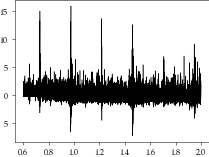

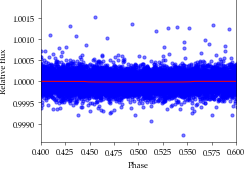

In [23]:


plt.figure()
plt.plot(
    results.model_folded_phase,
    results.model_folded_model,
    color='red')
plt.scatter(
    results.folded_phase,
    results.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2)
plt.xlim(0.4, 0.6)
plt.xlabel('Phase')
plt.ylabel('Relative flux');



In [44]:
import astropy.units as u

In [42]:
koi[koi.kepid == '6116172'][['koi_period', 'koi_time0bk', 'koi_duration']]

,koi_period,koi_time0bk,koi_duration
7450,69.646793,138.283056,3.710
7451,111.655460,148.893900,1.051
7452,86.132019,164.223699,3.110


In [45]:
tpfs = lk.search_targetpixelfile(f'KIC 6116172').download_all()
period = 69.646793
t0 = 138.283056
duration = (3.710 * u.hr).to(u.day).value

In [46]:
tpfs

TargetPixelFileCollection of 17 objects:
    0: KeplerTargetPixelFile Object (ID: 6116172)
    1: KeplerTargetPixelFile Object (ID: 6116172)
    2: KeplerTargetPixelFile Object (ID: 6116172)
    3: KeplerTargetPixelFile Object (ID: 6116172)
    4: KeplerTargetPixelFile Object (ID: 6116172)
    5: KeplerTargetPixelFile Object (ID: 6116172)
    6: KeplerTargetPixelFile Object (ID: 6116172)
    7: KeplerTargetPixelFile Object (ID: 6116172)
    8: KeplerTargetPixelFile Object (ID: 6116172)
    9: KeplerTargetPixelFile Object (ID: 6116172)
    10: KeplerTargetPixelFile Object (ID: 6116172)
    11: KeplerTargetPixelFile Object (ID: 6116172)
    12: KeplerTargetPixelFile Object (ID: 6116172)
    13: KeplerTargetPixelFile Object (ID: 6116172)
    14: KeplerTargetPixelFile Object (ID: 6116172)
    15: KeplerTargetPixelFile Object (ID: 6116172)
    16: KeplerTargetPixelFile Object (ID: 6116172)

Modeling TPFs: 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]


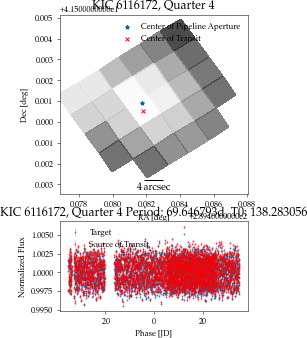

In [50]:
plt.style.use('science')
# for tpf in tpfs[:2]:
tpf = tpfs[3]
result = ct.calculate_contamination(tpf, period, t0, duration, plot=True, sff=False, spline_period=0.5, cbvs=True);
result[0]['fig']
#     f = result[0]['fig']
#     axes = f.axes
#     axes[0].set_title('')
#     axes[1].set_title('')
#     axes[1].set_xlim(-1,1)
#     f.show()
#     plt.show()
# f.savefig('contaminante.pdf', dpi=300, bbox_inches='tight')

In [33]:
plt.draw()

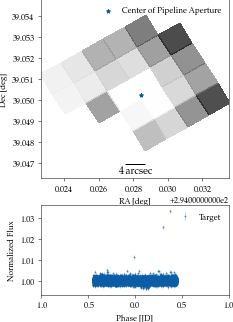

In [20]:
plt.style.use('science')
f = result[0]['fig']
axes = f.axes
axes[0].set_title('')
axes[1].set_title('')
axes[1].set_xlim(-1,1)
f

# f.savefig('contaminante.pdf', dpi=300, bbox_inches='tight')

In [81]:
fig = plt.figure(figsize=(17, 3.5))
ax = plt.subplot2grid((1, 4), (0, 0))
ax.set_title(_label(tpf))

if tpf.mission.lower() == "tess":
    pix = 27 * u.arcsec.to(u.deg)
elif tpf.mission.lower() in ["kepler", "ktwo", "k2"]:
    pix = 4 * u.arcsec.to(u.deg)
else:
    pix = 0

xlim = [1e10, -1e10]
ylim = [1e10, -1e10]
ra, dec = np.asarray(np.median(tpf.get_coordinates(), axis=1))
with np.errstate(divide="ignore"):
    ax.pcolormesh(
        ra,
        dec,
        np.log10(np.nanmedian(np.nan_to_num(tpf.flux.value), axis=0)),
        cmap="Greys_r",
        shading="auto",
    )
xlim[0] = np.min([np.percentile(ra, 1) - pix, xlim[0]])
xlim[1] = np.max([np.percentile(ra, 99) + pix, xlim[1]])
ylim[0] = np.min([np.percentile(dec, 1) - pix, ylim[0]])
ylim[1] = np.max([np.percentile(dec, 99) + pix, ylim[1]])
#        import pdb;pdb.set_trace()
ax.scatter(
    np.hstack(res["target_ra"]),
    np.hstack(res["target_dec"]),
    c="C0",
    marker=".",
    s=10,
    label="Center of Pipeline Aperture",
    zorder=11,
)
if "contaminator_ra" in res.keys():
    ax.scatter(
        np.hstack(res["contaminator_ra"]),
        np.hstack(res["contaminator_dec"]),
        c="r",
        marker=".",
        s=13,
        label="Center of Transit Pixels",
        zorder=10,
    )
ax.legend(frameon=True)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
if tpf.mission.lower() == "tess":
    scalebar = AnchoredSizeBar(
        ax.transData,
        27 * u.arcsec.to(u.deg),
        "27 arcsec",
        "lower center",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=27 / 100 * u.arcsec.to(u.deg),
    )
else:
    scalebar = AnchoredSizeBar(
        ax.transData,
        4 * u.arcsec.to(u.deg),
        "4 arcsec",
        "lower center",
        pad=0.1,
        color="black",
        frameon=False,
        size_vertical=4 / 100 * u.arcsec.to(u.deg),
    )

ax.add_artist(scalebar)
ax.set_xlabel("RA [deg]")
ax.set_ylabel("Dec [deg]")

ax = plt.subplot2grid((1, 4), (0, 1), colspan=3)
period, t0 = res["period"], res["t0"]
ax.set_title(_label(tpf) + f" Period: {period}d, T0: {t0}")
res["target_lc"].fold(period, t0).errorbar(
    c="C0", label="Target", ax=ax, marker=".", markersize=2
)
if "contaminator_lc" in res.keys():
    res["contaminator_lc"].fold(period, t0).errorbar(
        ax=ax,
        c="r",
        marker=".",
        label="Source of Transit",
        markersize=2,
    )

[{'target_depth': (7.045243454210597e-05, 2.8845582411804455e-06),
  'target_ra': (299.3843840794518, 5.796282016313424e-10),
  'target_dec': (40.75750329992266, 5.516542210649033e-10),
  'target_lc': <KeplerLightCurve length=4125 LABEL="KIC 5565497" QUARTER=3 CAMPAIGN=None>
         time               flux        ... cadenceno quality
                                        ...                  
        object            float64       ...   int32    int32 
  ------------------ ------------------ ... --------- -------
   260.2254504217417 0.9999281323526031 ...      7404       0
  260.24588353640866 1.0000561539896866 ...      7405       0
  260.26631655083474 1.0001307311122045 ...      7406       0
   260.2867494650345  1.000129998840742 ...      7407       0
  260.30718257877015 1.0000726675069507 ...      7408       0
   260.3276155922649 1.0000909093464472 ...      7409       0
  260.34804850553337  1.000115068516896 ...      7410       0
  260.36848151856975 1.0001129628262917 ..

(0.1348059764224196, 1000)

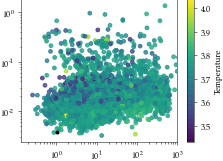

In [47]:
plt.scatter(koi.koi_period, #koi.koi_prad, 
            koi.koi_ror,
            c=np.log10(koi.koi_steff), 
            s=14,alpha=0.8)

# plt.plot(1.0726065,0.0038745,'.k')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='Temperature')
plt.xlim(None, 10**3)

In [16]:
17+16

33